# Dandiset 001174: Calcium Imaging in SMA and M1 of Macaques

**⚠️ Note: This notebook was AI-generated with human supervision and has not been fully verified. Please be cautious when interpreting the code or results.**

This dataset contains calcium imaging recordings from the supplementary motor area (SMA) and primary motor cortex (M1) of rhesus macaques during rest and arm-reaching tasks. The researchers used one-photon calcium imaging with miniature microscopes to study neuronal activity patterns in deep layers of these motor areas.

Key features of the dataset:
* 4 rhesus macaque subjects
* GCaMP6f calcium indicator
* One-photon imaging through GRIN lenses
* Recordings during rest and reaching tasks
* Multiple sessions per subject

## Getting Started

First, let's set up our Python environment and import the necessary packages:

In [1]:
import pynwb
import lindi
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Loading and Examining the Data

The data is stored in NWB (Neurodata Without Borders) format, with separate files for each recording session. Let's load an example session using the `lindi` package, which helps us stream the data efficiently:

In [2]:
# Load an example session (Subject F, spontaneous recording)
f = lindi.LindiH5pyFile.from_lindi_file("https://lindi.neurosift.org/dandi/dandisets/001174/assets/17963d0d-362d-40a3-aa7f-645c719f3f4a/nwb.lindi.json")
nwb = pynwb.NWBHDF5IO(file=f, mode='r').read()

# Print basic session information
print(f"Session description: {nwb.session_description}")
print(f"Subject: {nwb.subject.subject_id} ({nwb.subject.species})")
print(f"Session start time: {nwb.session_start_time}")

Session description: Calcium imaging in SMA during the spontaneous condition
Subject: F (Macaca mulatta)
Session start time: 2024-03-07 09:17:11.083000+00:00


/home/magland/miniconda3/envs/dev/lib/python3.12/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.7.0 because version 2.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


## Understanding the Data Structure

Each NWB file contains several key components:

1. Raw imaging data (OnePhotonSeries)
2. Processed fluorescence traces (Fluorescence/RoiResponseSeries)
3. Detected calcium events (EventAmplitude)
4. Cell footprints/ROIs (PlaneSegmentation)

Let's examine each of these components:

In [3]:
# 1. Raw imaging information
imaging = nwb.acquisition["OnePhotonSeries"]
print("\nImaging data:")
print(f"Dimensions: {imaging.data.shape} (frames × height × width)")
print(f"Sampling rate: {imaging.rate} Hz")
print(f"Recording duration: {len(imaging.data)/imaging.rate:.1f} seconds")

# 2. Number of detected cells
segmentation = nwb.processing["ophys"]["ImageSegmentation"]["PlaneSegmentation"]
n_cells = len(segmentation["image_mask"].data)
print(f"\nNumber of detected cells: {n_cells}")


Imaging data:
Dimensions: (12692, 1280, 800) (frames × height × width)
Sampling rate: 10.0 Hz
Recording duration: 1269.2 seconds

Number of detected cells: 6


## Visualizing Cell Locations

Each cell has a spatial "footprint" that shows where it was detected in the field of view. Let's visualize these:

Text(0, 0.5, 'Pixels')

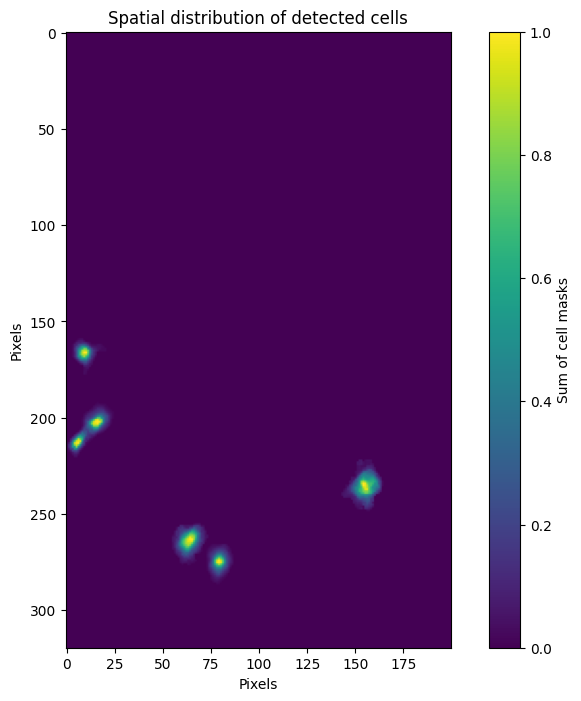

In [4]:
# Get cell footprints
footprints = segmentation["image_mask"].data[:]

# Sum all footprints to show cell locations
plt.figure(figsize=(10, 8))
footprint_sum = np.sum(footprints, axis=0)
plt.imshow(footprint_sum, cmap='viridis')
plt.colorbar(label='Sum of cell masks')
plt.title('Spatial distribution of detected cells')
plt.xlabel('Pixels')
plt.ylabel('Pixels')

## Analyzing Neural Activity

Now let's look at the fluorescence traces and detected events for these cells:

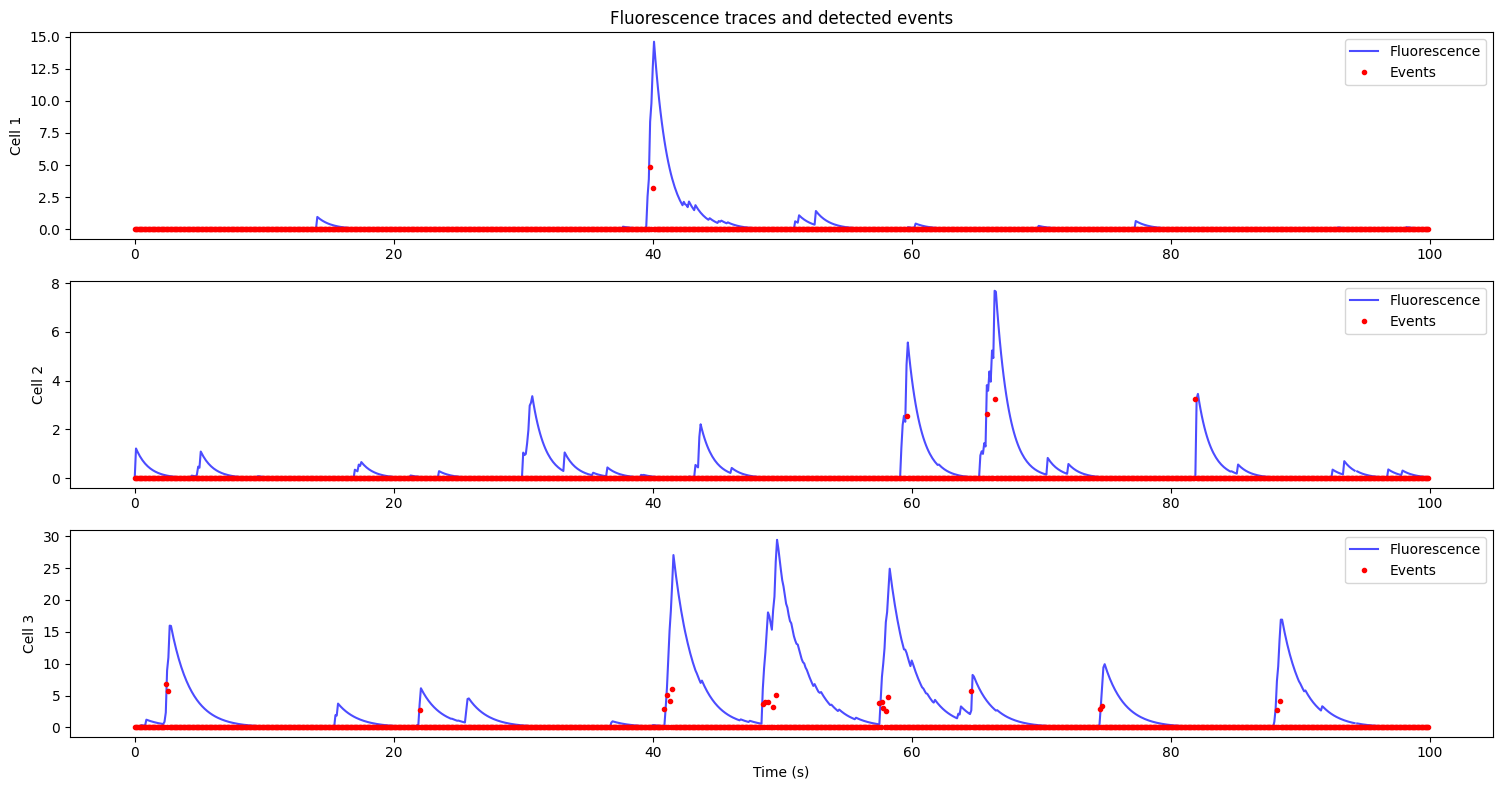

In [5]:
# Get fluorescence and events data
fluorescence = nwb.processing["ophys"]["Fluorescence"]["RoiResponseSeries"].data[:]
events = nwb.processing["ophys"]["EventAmplitude"].data[:]
time = np.arange(len(fluorescence)) / imaging.rate

# Plot first 100 seconds for 3 example cells
t_end = int(100 * imaging.rate)  # 100 seconds worth of frames
n_example_cells = min(3, n_cells)

plt.figure(figsize=(15, 8))
for i in range(n_example_cells):
    plt.subplot(n_example_cells, 1, i+1)
    plt.plot(time[:t_end], fluorescence[:t_end, i], 'b-', label='Fluorescence', alpha=0.7)
    plt.plot(time[:t_end], events[:t_end, i], 'r.', label='Events')
    plt.ylabel(f'Cell {i+1}')
    if i == 0:
        plt.title('Fluorescence traces and detected events')
    if i == n_example_cells-1:
        plt.xlabel('Time (s)')
    plt.legend()
plt.tight_layout()

## Basic Activity Statistics

Let's calculate some basic statistics about neural activity in this recording:


Activity Summary:
Average event rate: 0.12 events/second
Average event amplitude: 3.75


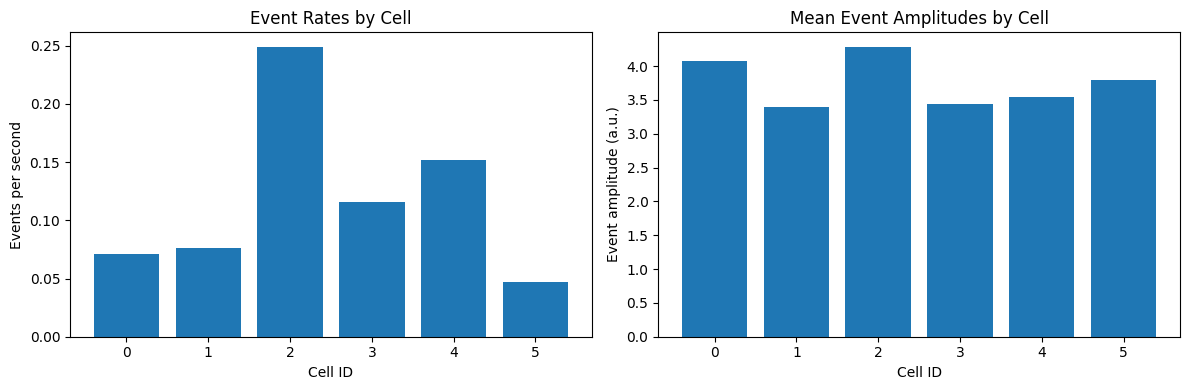

In [6]:
# Calculate event rates and mean amplitudes for each cell
def get_cell_stats(events, sampling_rate):
    event_rates = []
    mean_amplitudes = []

    for i in range(events.shape[1]):
        event_times = np.where(events[:, i] > 0)[0]
        event_rates.append(len(event_times) / (len(events) / sampling_rate))
        if len(event_times) > 0:
            mean_amplitudes.append(np.mean(events[event_times, i]))
        else:
            mean_amplitudes.append(0)

    return event_rates, mean_amplitudes

event_rates, mean_amplitudes = get_cell_stats(events, imaging.rate)

# Plot statistics
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.bar(range(n_cells), event_rates)
ax1.set_title('Event Rates by Cell')
ax1.set_xlabel('Cell ID')
ax1.set_ylabel('Events per second')

ax2.bar(range(n_cells), mean_amplitudes)
ax2.set_title('Mean Event Amplitudes by Cell')
ax2.set_xlabel('Cell ID')
ax2.set_ylabel('Event amplitude (a.u.)')

plt.tight_layout()

print("\nActivity Summary:")
print(f"Average event rate: {np.mean(event_rates):.2f} events/second")
print(f"Average event amplitude: {np.mean(mean_amplitudes):.2f}")

## Example Analysis: Looking for Correlated Activity

One interesting analysis we can do is look for cells that show correlated activity patterns, which might suggest functional connectivity or shared inputs:


Proportion of strongly correlated pairs (|r| > 0.5): 0.0%


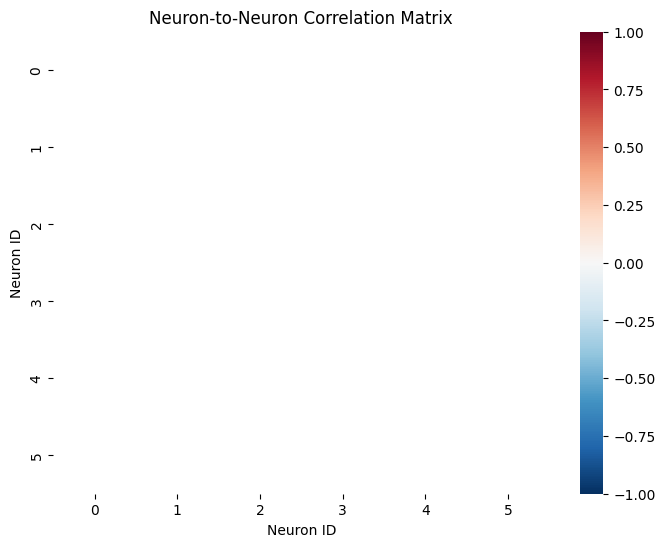

In [7]:
# Calculate correlation matrix of fluorescence traces
corr_matrix = np.corrcoef(fluorescence.T)

# Plot correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, cmap='RdBu_r', center=0, vmin=-1, vmax=1)
plt.title('Neuron-to-Neuron Correlation Matrix')
plt.xlabel('Neuron ID')
plt.ylabel('Neuron ID')

# Print summary of correlations
sig_threshold = 0.5
n_pairs = (n_cells * (n_cells - 1)) // 2
sig_corr_pairs = np.sum(np.abs(corr_matrix[np.triu_indices(n_cells, k=1)]) > sig_threshold)
print(f"\nProportion of strongly correlated pairs (|r| > {sig_threshold}): {sig_corr_pairs/n_pairs:.1%}")

## Working with Other Sessions

This dataset contains multiple recording sessions across different subjects. Here's how you can access other sessions:

1. Subject F: Contains spontaneous and reaching task recordings
2. Subject Q: Multiple sessions with varying conditions
3. Subject U: SMA recordings during rest and reaching
4. Subject V: Motor cortex recordings

To load a different session, you would modify the file URL in the initial loading step. For example, to load a different session from subject F:

```python
# Example of loading a different session (commented out)
# f = lindi.LindiH5pyFile.from_lindi_file("https://lindi.neurosift.org/dandi/dandisets/001174/assets/ASSET_ID_HERE/nwb.lindi.json")
```

## Research Applications

This dataset can be used to investigate several research questions:

1. How do individual neurons in SMA and M1 respond during reaching tasks?
2. Are there differences in activity patterns between rest and task periods?
3. Do neurons show coordinated activity patterns suggesting functional organization?
4. How stable are neural responses across sessions?

The combination of cellular resolution and behavioral context makes this dataset valuable for understanding motor cortex function in primates.